In [1]:
import pandas as pd 
import altair as alt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import tensorflow as tf

2023-10-30 09:47:51.962227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
NDVI4 = pd.read_csv('./ndvi_ppt_tempt_pasture_ctwd4.csv')

In [4]:
df = NDVI4[['Timestamp','ppt','tmean','DOY','Month','GDD','NDVI']]

In [5]:
df

,Timestamp,ppt,tmean,DOY,Month,GDD,NDVI
0,1980-12-31,0.0,1.810000,366,12,0.000000,NaN
1,1981-01-01,0.0,-1.893000,1,1,0.000000,NaN
2,1981-01-02,0.0,-0.549000,2,1,0.000000,NaN
3,1981-01-03,0.0,-3.754000,3,1,0.000000,NaN
4,1981-01-04,0.0,-4.703000,4,1,0.000000,NaN
...,...,...,...,...,...,...,...
15566,2023-08-14,0.0,18.735300,226,8,1667.664637,0.241827
15567,2023-08-15,0.0,24.603699,227,8,1687.268335,NaN
15568,2023-08-16,0.0,23.907598,228,8,1706.175934,NaN
15569,2023-08-17,0.0,21.076500,229,8,1722.252434,NaN


In [6]:
# df['NDVI'].fillna(method='ffill',inplace=True)

In [7]:
df_vis = df.copy()

In [8]:
# scale for better visualization 
time_period = slice(10000,15000)
df_vis['NDVI_scaled'] = df_vis['NDVI'] * 100
df_vis['GDD_scaled'] = df_vis['GDD']/100

# df_vis = df_vis.reset_index()
tmean = alt.Chart(df_vis.iloc[time_period]).mark_bar(color='red',size=.2).encode(
alt.X("Timestamp:T"), alt.Y("tmean:Q"),
    tooltip=[
        alt.Tooltip('DOY:O', title='DOY'),
        alt.Tooltip('tmean:Q', title='tmean')]
)

precip = alt.Chart(df_vis.iloc[time_period]).mark_bar(color='blue',size=1).encode(
    alt.X("Timestamp:T"), alt.Y("ppt:Q"),
    tooltip=[
        alt.Tooltip('DOY:O', title='DOY'),
        alt.Tooltip('ppt:Q', title='ppt')]
)

ndvi = alt.Chart(df_vis.iloc[time_period]).mark_point(color='black',size=5).encode(
    alt.X("Timestamp:T"), alt.Y("NDVI_scaled:Q"),
    tooltip=[
        alt.Tooltip('DOY:O', title='DOY'),
        alt.Tooltip('NDVI:Q', title='NDVI')]
)

GDD = alt.Chart(df_vis.iloc[time_period]).mark_point(size=1).encode(
alt.X("Timestamp:T"), alt.Y("GDD_scaled:Q"),
    tooltip=[
        alt.Tooltip('DOY:O', title='DOY'),
        alt.Tooltip('GDD:Q', title='GDD')]
)



(tmean + precip + ndvi + GDD).properties(width=2000, height=500)

/Users/vahid/opt/anaconda3/envs/pygee/lib/python3.11/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/vahid/opt/anaconda3/envs/pygee/lib/python3.11/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/vahid/opt/anaconda3/envs/pygee/lib/python3.11/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dt

alt.LayerChart(...)

In [6]:
df.loc[:,'ppt'] = pd.to_numeric(df['ppt'])
df.loc[:,'tmean'] = pd.to_numeric(df['tmean'])
df.loc[:,'Timestamp'] = pd.to_datetime(df['Timestamp']) 

In [11]:
tf.keras.utils.timeseries_dataset_from_array()

<function keras.src.utils.timeseries_dataset.timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride=1, sampling_rate=1, batch_size=128, shuffle=False, seed=None, start_index=None, end_index=None)>

In [12]:
df_dropna = df.dropna()

In [13]:
df_dropna = df_dropna.set_index('Timestamp')

In [42]:
ndvi_train = df_dropna['NDVI']['1982-11-16':'2016-01-01']
ndvi_val = df_dropna['NDVI']['2016-01-01':'2017-01-01']
ndvi_test = df_dropna['NDVI']['2017-01-01':]

In [46]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
  ndvi_train.to_numpy(),
  targets=ndvi_train[seq_length:],
  sequence_length=seq_length,
  batch_size=32, 
  shuffle=True, 
  seed=42)

In [48]:
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
      ndvi_val.to_numpy(),
      targets=ndvi_val[seq_length:],
      sequence_length=seq_length,
      batch_size=32
)

In [50]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping( monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt,
metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds,
epochs=500,
                  callbacks=[early_stopping_cb])

Epoch 1/500
19/19 [==============================] - 0s 6ms/step - loss: 0.0068 - mae: 0.0944
Epoch 2/500
19/19 [==============================] - 0s 5ms/step - loss: 0.0058 - mae: 0.0875
Epoch 3/500
19/19 [==============================] - 0s 5ms/step - loss: 0.0050 - mae: 0.0812
Epoch 4/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0045 - mae: 0.0765
Epoch 5/500
19/19 [==============================] - 0s 5ms/step - loss: 0.0041 - mae: 0.0725
Epoch 6/500
19/19 [==============================] - 0s 5ms/step - loss: 0.0036 - mae: 0.0686
Epoch 7/500
19/19 [==============================] - 0s 5ms/step - loss: 0.0034 - mae: 0.0655
Epoch 8/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0031 - mae: 0.0626
Epoch 9/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0601
Epoch 10/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0577
Epoch 11/500
19/19 [==============================] - 0s 5m

In [57]:
model = tf.keras.Sequential([ tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [360]:
df = df.reset_index()

In [14]:
from sklearn.model_selection import train_test_split

In [25]:
def lstm_model(df, 
               time_window=5,
               feature_list = ['tmean','ppt','DOY','GDD'],  
               test_fraction = .1, 
               val_fraction = .1, 
               batch_size = 32,
               number_epochs = 1000): 
    number_of_sequences = len(df['NDVI'].dropna().index)
    data = [df[feature_list].iloc[index:index-time_window:-1].to_numpy() for index in df['NDVI'].dropna().index]   
    data = np.array(data)
    X = data
    y = df['NDVI'].dropna().to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_fraction,shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_fraction,shuffle=False)
    batch_size = 20
    number_features = len(feature_list)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)
    
    deep_LSTM = tf.keras.Sequential([ 
    tf.keras.layers.LSTM(120, return_sequences=True, input_shape=[time_window, number_features]),
    
    tf.keras.layers.LSTM(32, return_sequences=True), 
    tf.keras.layers.LSTM(32), 
    tf.keras.layers.Dense(1)
    ])
    deep_LSTM.compile(loss = 'mean_squared_error', metrics=['mean_squared_error'],optimizer='adam')
    history=deep_LSTM.fit(X_train, y_train, epochs=number_epochs, validation_data=(X_val,y_val),batch_size=batch_size,verbose=0,callbacks=[early_stopping_cb])
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']
    model_prediction = deep_LSTM.predict(X_test,verbose=0)
    model_prediction = model_prediction.reshape(len(model_prediction),)
    test_loss = mean_squared_error(y_test,model_prediction)
    r2 = r2_score(y_test,model_prediction)
    print(f"train loss : {train_loss[-1]:.{5}f}.")
    print(f"validation loss : {val_loss[-1]:.{5}f}.")
    print(f"test loss : {test_loss:.{5}f}.")
    print(f"r2 : {r2:.{5}f}.") 
    return train_loss, val_loss, model_prediction, y_test

In [26]:
train_loss, val_loss, model_prediction, y_test = lstm_model(df.reset_index(),time_window=40,feature_list=['tmean','ppt'])

train loss : 0.00031.
validation loss : 0.00112.
test loss : 0.00106.
r2 : 0.73059.


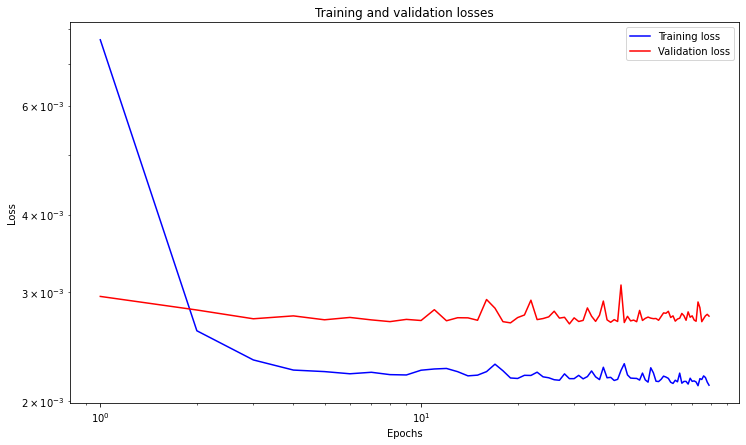

In [17]:
# train_loss=history.history['loss']
# val_loss=history.history['val_loss']
epochs=range(1,len(train_loss)+1)
plt.figure(figsize=(12,7))
plt.plot(epochs, train_loss,'b', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [101]:
# df = df.set_index('Timestamp')

In [102]:
df_test = df[['NDVI']].reset_index().dropna().iloc[-len(y_test):]

In [103]:
timestamps_test = df_test.reset_index()['Timestamp']
time_start_test = timestamps_test.iloc[0]
df_test_with_all_values = df[time_start_test:]

In [104]:
y_test_df= pd.DataFrame(y_test,columns=['y_test'])
# long_term_preds_df = pd.DataFrame(long_term_forecast,columns=['preds_all_time'])
model_prediction_df = pd.DataFrame(model_prediction.reshape(len(model_prediction),1),columns=['preds'])

In [105]:
y_test_df['Timestamp'] = timestamps_test
model_prediction_df['Timestamp'] = timestamps_test

In [106]:
df_test_with_all_values = df_test_with_all_values.reset_index()

In [107]:
df_test_with_all_values.loc[:,'ppt_scaled'] = .008 * df_test_with_all_values['ppt'] 
df_test_with_all_values.loc[:,'tmean_scaled'] = .01 * df_test_with_all_values['tmean']

In [108]:

df_all_NDVI = alt.Chart(df_test_with_all_values.reset_index()).mark_point(color='black',opacity=1, size=5).encode(
    alt.X("Timestamp:T"), 
    alt.Y("NDVI:Q")
)


df_all_pastppt = alt.Chart(df_test_with_all_values.reset_index()).mark_line(color='blue',opacity=1, size=1).encode(
    alt.X("Timestamp:T"), 
    alt.Y("past_56_sum_ppt_scalded:Q")
)


df_all_ppt = alt.Chart(df_test_with_all_values.reset_index()).mark_bar(color='blue',opacity=1, size=1.5).encode(
    alt.X("Timestamp:T"), 
    alt.Y("ppt_scaled:Q")
)



df_all_tmean = alt.Chart(df_test_with_all_values.reset_index()).mark_bar(color='red',opacity=.5, size=1.5).encode(
    alt.X("Timestamp:T"), 
    alt.Y("tmean_scaled:Q")
)


#predictions 
y_test_df_plot = alt.Chart(y_test_df.reset_index()).mark_line(color='black',opacity=1, size=1,point={
      "filled": True,
      "fill": "black",
    "size" : 50,
    'opacity' : .5
    }).encode(
    alt.X("Timestamp:T"), 
    alt.Y("y_test:Q"),
    tooltip=[
        alt.Tooltip('y_test:O', title='NDVI')]
)
model_prediction_plot = alt.Chart(model_prediction_df.reset_index()).mark_line(color='blue',opacity=1,size=2,point={
      "filled": True,
      "fill": "lime",
    "size" : 50
    }).encode(
    alt.X("Timestamp:T"), 
    alt.Y("preds:Q"),
    tooltip=[
        alt.Tooltip('preds:O', title='NDVI_prediction')]
)



(df_all_NDVI+ df_all_ppt+ df_all_tmean + y_test_df_plot + model_prediction_plot).properties(width=1500, height=600)

alt.LayerChart(...)

In [82]:
time_window= 3
feature_list= ['tmean','ppt']
data = [df[feature_list].iloc[index:index-time_window:-1].to_numpy() for index in df['NDVI'].dropna().index]   
np.array(data).shape

(958, 3, 2)

In [9]:
df

,Timestamp,ppt,tmean,DOY,Month,GDD,NDVI
0,1980-12-31,0.0,1.810000,366,12,0.000000,NaN
1,1981-01-01,0.0,-1.893000,1,1,0.000000,NaN
2,1981-01-02,0.0,-0.549000,2,1,0.000000,NaN
3,1981-01-03,0.0,-3.754000,3,1,0.000000,NaN
4,1981-01-04,0.0,-4.703000,4,1,0.000000,NaN
...,...,...,...,...,...,...,...
15566,2023-08-14,0.0,18.735300,226,8,1667.664637,0.241827
15567,2023-08-15,0.0,24.603699,227,8,1687.268335,NaN
15568,2023-08-16,0.0,23.907598,228,8,1706.175934,NaN
15569,2023-08-17,0.0,21.076500,229,8,1722.252434,NaN


In [26]:
df_test = pd.DataFrame({"f":[10. ,20,30,40,50,60,70,80,90],"h":[100. ,200,300,400,500,600,700,800,900],"g":[None,None,3., 4,None,6,7,None,9]})

In [27]:
df_test

,f,h,g
0,10.0,100.0,NaN
1,20.0,200.0,NaN
2,30.0,300.0,3.0
3,40.0,400.0,4.0
4,50.0,500.0,NaN
5,60.0,600.0,6.0
6,70.0,700.0,7.0
7,80.0,800.0,NaN
8,90.0,900.0,9.0


In [64]:
df_test['g'].dropna().index

Index([2, 3, 5, 6, 8], dtype='int64')

In [65]:
df_test[feature].iloc[2:2-2:-1]

2    30.0
1    20.0
Name: f, dtype: float64

In [127]:
feature = "f"
time_window = 2
labes = df_test['g'].dropna()
# index-time_window+1:index+1 this is also an option. Does it make any difference
data = [df_test[feature].iloc[index-time_window+1:index+1].to_numpy() for index in labes.index]
data1 = np.array(data)
data1

array([[20., 30.],
       [30., 40.],
       [50., 60.],
       [60., 70.],
       [80., 90.]])

In [128]:
feature = "h"
time_window = 2
labes = df_test['g'].dropna()
data = [df_test[feature].iloc[index-time_window+1:index+1].to_numpy() for index in labes.index]
data2 = np.array(data)
data2

array([[200., 300.],
       [300., 400.],
       [500., 600.],
       [600., 700.],
       [800., 900.]])

In [49]:
def data_gen(df,res = 'NDVI', features=['ppt','tmean'],p_res=1,p_feats=(2,2)):
    labes = df[res].dropna()[p_res:]
    past_labels = df[res].dropna()
    past_labels = sliding_window_view(past_labels,p_res)[:-1]
    past_predictors = np.hstack([np.array([df[feature].iloc[index-time_window+1:index+1] for index in labes.index]) for feature,time_window in zip(features,p_feats)])
    X = np.hstack((past_labels,past_predictors))
    y = np.array(labes)
    return X,y

In [255]:
p_res = 3
labels = df_test['g'].dropna()[p_res:]
labels

6    7.0
8    9.0
Name: g, dtype: float64

In [256]:
past_labels = df_test['g'].dropna()[:-1]
past_labels

2    3.0
3    4.0
5    6.0
6    7.0
Name: g, dtype: float64

In [260]:
sliding_window_view(past_labels,2)

array([[3., 4.],
       [4., 6.],
       [6., 7.]])

In [21]:
df_test

NameError: name 'df_test' is not defined

In [29]:
data_gen(df_test,res = 'g', features = ["f","h"],p_res = 3,p_feats = (2,2))

(array([[  3.,   4.,   6.,  60.,  70., 600., 700.],
        [  4.,   6.,   7.,  80.,  90., 800., 900.]]),
 array([7., 9.]))

In [30]:
sw_res_feats(df_test,res = 'g', features = ["f","h"],p_res = 3,p_feats = (2,2))

(array([[  3.,   4.,   6.,  60.,  70., 600., 700.],
        [  4.,   6.,   7.,  80.,  90., 800., 900.]]),
 array([7., 9.]))

In [225]:
df_test

,f,h,g
0,10.0,100.0,NaN
1,20.0,200.0,NaN
2,30.0,300.0,3.0
3,40.0,400.0,4.0
4,50.0,500.0,NaN
5,60.0,600.0,6.0
6,70.0,700.0,7.0
7,80.0,800.0,NaN
8,90.0,900.0,9.0


In [29]:
df['year'] = pd.DatetimeIndex(df['Timestamp']).year

/var/folders/sz/44hp86gj0lq16_fywprf9r580000gn/T/ipykernel_37586/1987328335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = pd.DatetimeIndex(df['Timestamp']).year


In [30]:
df

,Timestamp,ppt,tmean,DOY,Month,GDD,NDVI,year
0,1980-12-31,0.0,1.810000,366,12,0.000000,NaN,1980
1,1981-01-01,0.0,-1.893000,1,1,0.000000,NaN,1981
2,1981-01-02,0.0,-0.549000,2,1,0.000000,NaN,1981
3,1981-01-03,0.0,-3.754000,3,1,0.000000,NaN,1981
4,1981-01-04,0.0,-4.703000,4,1,0.000000,NaN,1981
...,...,...,...,...,...,...,...,...
15566,2023-08-14,0.0,18.735300,226,8,1667.664637,0.241827,2023
15567,2023-08-15,0.0,24.603699,227,8,1687.268335,NaN,2023
15568,2023-08-16,0.0,23.907598,228,8,1706.175934,NaN,2023
15569,2023-08-17,0.0,21.076500,229,8,1722.252434,NaN,2023


In [ ]:
df_test = df.iloc[]

In [44]:
df = df.set_index('Timestamp')

In [45]:
df

,ppt,tmean,DOY,Month,GDD,NDVI,year
Timestamp,,,,,,,
1980-12-31,0.0,1.810000,366,12,0.000000,NaN,1980
1981-01-01,0.0,-1.893000,1,1,0.000000,NaN,1981
1981-01-02,0.0,-0.549000,2,1,0.000000,NaN,1981
1981-01-03,0.0,-3.754000,3,1,0.000000,NaN,1981
1981-01-04,0.0,-4.703000,4,1,0.000000,NaN,1981
...,...,...,...,...,...,...,...
2023-08-14,0.0,18.735300,226,8,1667.664637,0.241827,2023
2023-08-15,0.0,24.603699,227,8,1687.268335,NaN,2023
2023-08-16,0.0,23.907598,228,8,1706.175934,NaN,2023


In [46]:
df["1981-01-01":"1982-01-01"]

,ppt,tmean,DOY,Month,GDD,NDVI,year
Timestamp,,,,,,,
1981-01-01,0.000,-1.893000,1,1,0.000000,NaN,1981
1981-01-02,0.000,-0.549000,2,1,0.000000,NaN,1981
1981-01-03,0.000,-3.754000,3,1,0.000000,NaN,1981
1981-01-04,0.000,-4.703000,4,1,0.000000,NaN,1981
1981-01-05,0.000,3.313000,5,1,0.000000,NaN,1981
...,...,...,...,...,...,...,...
1981-12-28,0.000,-8.705001,362,12,2560.318183,NaN,1981
1981-12-29,0.000,-11.460001,363,12,2560.318183,NaN,1981
1981-12-30,1.266,-13.685000,364,12,2560.318183,NaN,1981


In [51]:
from numpy.lib.stride_tricks import sliding_window_view


In [63]:
X,y = data_gen(df.reset_index(),res = 'NDVI', features=['ppt','tmean'],p_res=2,p_feats=(2,1))

In [64]:
X.shape

(956, 5)

In [66]:
np.array(df['NDVI'].dropna()[2:]).shape

(956,)

In [57]:
XX,yy = sw_res_feats(df,res = 'NDVI', features=['ppt','tmean'],p_res=0,p_feats=(0,1))

In [58]:
(X==XX).all()

True

In [59]:
(yy == y).all()

True

In [168]:
features = ["f","h"]
p_feats = (2,2)
p_res = 1
labes = df_test['g'].dropna()[p_res:]

In [188]:
past_labels = np.array(df_test['g'].dropna()[:-p_res])
past_labels = past_labels.reshape(len(past_labels),1)

In [189]:
past_predictors = np.hstack([np.array([df_test[feature].iloc[index-time_window+1:index+1].to_numpy() for index in labes.index]) for feature,time_window in zip(features,p_feats)])

In [190]:
np.hstack((past_labels,past_predictors))

array([[  3.,  30.,  40., 300., 400.],
       [  4.,  50.,  60., 500., 600.],
       [  6.,  60.,  70., 600., 700.],
       [  7.,  80.,  90., 800., 900.]])

In [75]:
p_res = 4

In [77]:
labes = df['NDVI'].dropna()[p_res:]

In [79]:
labes.shape

(954,)

In [66]:
past_labels = df['NDVI'].dropna()

In [69]:
len(past_labels)

958

In [74]:
sliding_window_view(past_labels,4)[:-1].shape

(954, 4)

In [64]:
from numpy.lib.stride_tricks import sliding_window_view

In [15]:
from numpy.lib.stride_tricks import sliding_window_view
def sw_res_feats(df,res = 'NDVI', features=['ppt','tmean'],p_res=1,p_feats=(2,2)):
    res_values = df[res].values
    features_values = [df[f].values for f in features]
    v = []
    for index,res in enumerate(res_values):
            if ~np.isnan(res):
                ll = [l[index-p+1:index+1] for l,p in zip(features_values,p_feats)]
                v.append((index,res,ll))

    res = [i[1]for i in v]
    res_sw = sliding_window_view([i[1]for i in v],p_res)[:-1]
    features_sw = [np.array([v[i][2][j] for i in range(p_res,len(v))]) for j in range(len(features))]
    X = np.hstack([res_sw,*features_sw])
    y = np.array(res)[p_res:]
    assert len(X) == len(y)
    return X,y

In [142]:
sw_res_feats(df_test,res='g',features=['f','h'],p_res=1,p_feats=(2,2))

(array([[  3.,  30.,  40., 300., 400.],
        [  4.,  50.,  60., 500., 600.],
        [  6.,  60.,  70., 600., 700.],
        [  7.,  80.,  90., 800., 900.]]),
 array([4., 6., 7., 9.]))

In [141]:
df_test

,f,h,g
0,10.0,100.0,NaN
1,20.0,200.0,NaN
2,30.0,300.0,3.0
3,40.0,400.0,4.0
4,50.0,500.0,NaN
5,60.0,600.0,6.0
6,70.0,700.0,7.0
7,80.0,800.0,NaN
8,90.0,900.0,9.0


In [13]:
feature = "tmean"
time_window = 4

In [15]:
[df[feature].iloc[index:index-time_window:-1].to_numpy() for index in df['NDVI'].dropna().index]   

[array([-0.48600003, -0.26500002, -3.71000028, -4.71500015]),
 array([ 8.14100075,  9.57500076, 13.18800068, 10.7840004 ]),
 array([17.00200081, 13.6590004 , 16.75500107, 13.06600094]),
 array([24.10700035, 23.88100052, 21.34000015, 19.61600113]),
 array([21.02000046, 21.51600075, 20.9260006 , 24.10700035]),
 array([17.02300072, 18.05700111, 16.29000092, 20.73500061]),
 array([  3.53900027,   4.0090003 ,  -2.78000021, -12.46500015]),
 array([-11.45100021, -12.51900101,  -5.10100031,  -0.38000003]),
 array([-20.11200142, -19.79700089, -22.40200043, -14.63600063]),
 array([-0.76900005, -1.83800006,  1.13900006, -5.18300009]),
 array([-1.54000008, -0.49000001,  3.16900015, -1.45800006]),
 array([16.46000099, 15.17500114,  9.39800072, 12.49400043]),
 array([15.58600044, 13.07300091, 19.28800011, 18.2670002 ]),
 array([24.65400124, 16.66200066, 14.88400078, 12.09000015]),
 array([24.89600182, 19.29200172, 24.354002  , 27.72700119]),
 array([24.82800102, 23.15400124, 23.7480011 , 24.94900131

In [6]:
from src.NARX_model import arx_model
from keras.models import Sequential
from keras.layers import Dense 
from keras.callbacks import EarlyStopping

In [131]:
features_list = ['ppt','tmean','GDD','DOY']

In [132]:
p_feats=(1,2,0,0)
p_res=1
input_dimension = sum(p_feats) + p_res

In [133]:
deep_model = Sequential()
deep_model.add(Dense(100, activation='sigmoid',use_bias=True,input_dim=input_dimension))
# model.add(Dense(100,activation='sigmoid'))
# model.add(Dense(100,activation='sigmoid'))
# model.add(Dense(50,activation='sigmoid'))
# deep_model.add(Dense(40, activation='sigmoid',use_bias=True,input_dim=input_dimension))
deep_model.add(Dense(30,activation='sigmoid'))
deep_model.add(Dense(1,activation='sigmoid'))
deep_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 100)               500       
                                                                 
 dense_58 (Dense)            (None, 30)                3030      
                                                                 
 dense_59 (Dense)            (None, 1)                 31        
                                                                 
Total params: 3561 (13.91 KB)
Trainable params: 3561 (13.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [134]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only = True)
early_stopping = keras.callbacks.EarlyStopping(patience=30)

In [135]:
model, history, X_test, y_test, model_prediction, r2,train_loss, test_loss = arx_model(df.reset_index(),deep_model,p_feats=p_feats,p_res=p_res,number_epochs=1500,features=features_list,callbacks=[early_stopping])

train loss : 0.00090.
validation loss : 0.00064.
test loss : 0.00052.
r2 : 0.86831.


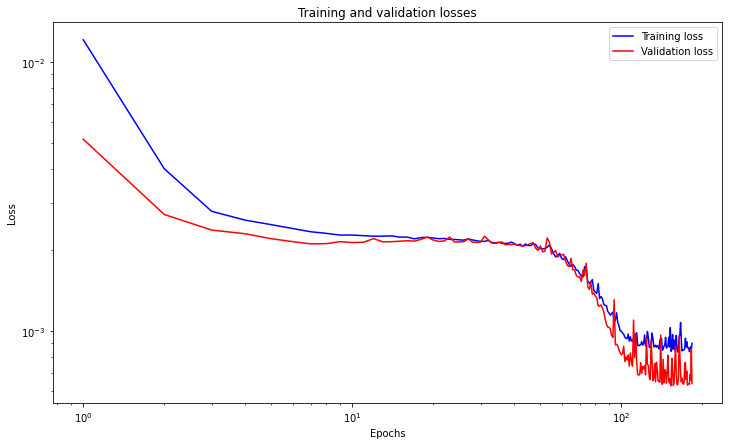

In [136]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(train_loss)+1)
plt.figure(figsize=(12,7))
plt.plot(epochs, train_loss,'b', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [139]:
# df = df.set_index('Timestamp')

In [140]:
df_test = df[['NDVI']].reset_index().dropna().iloc[-len(y_test):]
timestamps_test = df_test.reset_index()['Timestamp']
time_start_test = timestamps_test.iloc[0]
df_test_with_all_values = df[time_start_test:]
y_test_df= pd.DataFrame(y_test,columns=['y_test'])
model_prediction_df = pd.DataFrame(model_prediction.reshape(len(model_prediction),1),columns=['preds'])
y_test_df['Timestamp'] = timestamps_test
model_prediction_df['Timestamp'] = timestamps_test
df_test_with_all_values = df_test_with_all_values.reset_index()
df_test_with_all_values.loc[:,'ppt_scaled'] = .008 * df_test_with_all_values['ppt'] 
df_test_with_all_values.loc[:,'tmean_scaled'] = .01 * df_test_with_all_values['tmean']

In [141]:

df_all_NDVI = alt.Chart(df_test_with_all_values.reset_index()).mark_point(color='black',opacity=1, size=5).encode(
    alt.X("Timestamp:T"), 
    alt.Y("NDVI:Q")
)


df_all_pastppt = alt.Chart(df_test_with_all_values.reset_index()).mark_line(color='blue',opacity=1, size=1).encode(
    alt.X("Timestamp:T"), 
    alt.Y("past_56_sum_ppt_scalded:Q")
)


df_all_ppt = alt.Chart(df_test_with_all_values.reset_index()).mark_bar(color='blue',opacity=1, size=1.5).encode(
    alt.X("Timestamp:T"), 
    alt.Y("ppt_scaled:Q")
)



df_all_tmean = alt.Chart(df_test_with_all_values.reset_index()).mark_bar(color='red',opacity=.5, size=1.5).encode(
    alt.X("Timestamp:T"), 
    alt.Y("tmean_scaled:Q")
)


#predictions 
y_test_df_plot = alt.Chart(y_test_df.reset_index()).mark_line(color='black',opacity=1, size=1,point={
      "filled": True,
      "fill": "black",
    "size" : 50,
    'opacity' : .5
    }).encode(
    alt.X("Timestamp:T"), 
    alt.Y("y_test:Q"),
    tooltip=[
        alt.Tooltip('y_test:O', title='NDVI')]
)
model_prediction_plot = alt.Chart(model_prediction_df.reset_index()).mark_line(color='blue',opacity=1,size=2,point={
      "filled": True,
      "fill": "lime",
    "size" : 50
    }).encode(
    alt.X("Timestamp:T"), 
    alt.Y("preds:Q"),
    tooltip=[
        alt.Tooltip('preds:O', title='NDVI_prediction')]
)


(df_all_NDVI+ df_all_ppt+ df_all_tmean + y_test_df_plot + model_prediction_plot).properties(width=1500, height=600)

/Users/vahid/opt/anaconda3/envs/pygee/lib/python3.11/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/vahid/opt/anaconda3/envs/pygee/lib/python3.11/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/vahid/opt/anaconda3/envs/pygee/lib/python3.11/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dt

alt.LayerChart(...)